In [1]:
import os

import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import transformers

from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator 

import sentence_transformers
from sklearn import preprocessing

from sklearn import model_selection


plt.style.use("dark_background")
%matplotlib inline

In [2]:
%cd ..

/home/kuba/Projects/github_search


In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
pd.set_option("display.max_colwidth", 150)

In [5]:
doc_id_t5_path = "output/doc_id_generation_model/best_checkpoint/"

In [6]:
model = transformers.T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-base-multi-sum")#("output/doc_id_generation_model/best_checkpoint/")

In [7]:
#tokenizer = transformers.AutoTokenizer.from_pretrained("output/doc_id_generation_model/best_checkpoint/")

In [8]:
#model = model.cuda().half()

In [9]:
imports_df = pd.read_feather("output/selected_python_files_imports.feather")
files_df = pd.read_feather("output/selected_python_files.feather")

In [10]:
def get_predicted_path_summary(texts, n_beams=16, max_length=256, max_label_length=64, min_length=32):
    inputs = tokenizer(texts, max_length=max_length,  truncation=True,
                        padding="max_length", return_tensors="pt")
    summaries = model.generate(input_ids=inputs["input_ids"].to(model.device),
                     attention_mask=inputs["attention_mask"].to(model.device),
                     length_penalty=0.8, num_beams=n_beams, max_length=max_label_length, min_length=min_length)
    return tokenizer.batch_decode(summaries, skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [11]:
import datasets
from functools import partial
import ast
from github_search import seq2seq_utils

In [12]:
paperswithcode_df = pd.read_csv("output/papers_with_readmes.csv")

In [13]:
imports_df = pd.read_feather("output/selected_python_files_imports.feather")
files_df = pd.read_feather("output/selected_python_files.feather")

In [14]:
repo_tasks = paperswithcode_df['tasks'].apply(lambda ts: ", ".join(ast.literal_eval(ts)))
repo_tasks = pd.DataFrame({"repo": paperswithcode_df['repo'], "tasks": repo_tasks})

In [15]:
files_with_tasks_df = repo_tasks.merge(files_df, on='repo')

In [16]:
seq2seq_dataset = datasets.load_from_disk("output/seq2seq_hf_dataset/")

In [17]:
paperswithcode_area_ds= datasets.Dataset.from_pandas(pd.read_csv("data/paperswithcode_tasks.csv").dropna()[['area', 'task_description']])

In [18]:
files_with_tasks_df.head()

,repo,tasks,similarity,path,content
0,000Justin000/torchdiffeq,"latent variable models, multivariate time series forecasting, multivariate time series imputation",0.536278,torchdiffeq/_impl/odeint.py,"from .tsit5 import Tsit5Solver\nfrom .dopri5 import Dopri5Solver\nfrom .fixed_grid import Euler, Midpoint, RK4\nfrom .fixed_adams import AdamsBash..."
1,000Justin000/torchdiffeq,"latent variable models, multivariate time series forecasting, multivariate time series imputation",0.402928,torchdiffeq/_impl/rk_common.py,# Based on https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/integrate\nimport collections\nfrom .misc import _scaled_dot_pr...
2,000Justin000/torchdiffeq,"latent variable models, multivariate time series forecasting, multivariate time series imputation",0.400493,torchdiffeq/_impl/interp.py,"import torch\nfrom .misc import _convert_to_tensor, _dot_product\n\n\ndef _interp_fit(y0, y1, y_mid, f0, f1, dt):\n """"""Fit coefficients for 4th..."
3,000Justin000/torchdiffeq,"latent variable models, multivariate time series forecasting, multivariate time series imputation",0.343509,torchdiffeq/_impl/adjoint.py,"import torch\nimport torch.nn as nn\nfrom . import odeint\nfrom .misc import _flatten, _flatten_convert_none_to_zeros\n\n\nclass OdeintAdjointMeth..."
4,000Justin000/torchdiffeq,"latent variable models, multivariate time series forecasting, multivariate time series imputation",0.298963,torchdiffeq/_impl/misc.py,import warnings\nimport torch\n\n\ndef _flatten(sequence):\n flat = [p.contiguous().view(-1) for p in sequence]\n return torch.cat(flat) if ...


In [19]:
plbart_str = "uclanlp/plbart-single_task-en_python"#uclanlp/plbart-python-en_XX"

In [43]:
cross_encoder = sentence_transformers.cross_encoder.CrossEncoder("microsoft/codebert-base", max_length=512, num_labels=1)

In [21]:
sample_files_with_tasks_df = files_with_tasks_df.iloc[::25].reset_index()

In [22]:
sample_files_with_tasks_df.head()

,index,repo,tasks,similarity,path,content
0,0,000Justin000/torchdiffeq,"latent variable models, multivariate time series forecasting, multivariate time series imputation",0.536278,torchdiffeq/_impl/odeint.py,"from .tsit5 import Tsit5Solver\nfrom .dopri5 import Dopri5Solver\nfrom .fixed_grid import Euler, Midpoint, RK4\nfrom .fixed_adams import AdamsBash..."
1,25,011235813/SEPT,variational inference,0.291831,alg/train_baseline.py,"""""""\nBaseline 1: \nTraining: train a single policy on all training instances, for many episodes per instance.\nTest: execute the trained policy on..."
2,50,011235813/hierarchical-marl,"multi agent reinforcement learning, q learning",0.160598,test/test_env_selfplay.py,import sys\nimport random\nimport json\n\nsys.path.append('../env/')\n\nimport numpy as np\nimport tensorflow as tf\n\nimport env_wrapper\n\nwith ...
3,75,0492wzl/tensorflow_slim_densenet,"crowd counting, image classification, object recognition, person re identification",0.181351,datasets/download_and_convert_cifar10.py,"# Copyright 2016 The TensorFlow Authors. All Rights Reserved.\n#\n# Licensed under the Apache License, Version 2.0 (the ""License"");\n# you may not..."
4,100,08173021/YOLOv4,"data augmentation, object detection",0.100642,demo_onnx.py,import sys\nimport onnx\nimport os\nimport argparse\nimport numpy as np\nimport cv2\nimport onnxruntime\nfrom tool.utils import *\n\n\ndef main(on...


In [23]:
sample_files_with_tasks_df['tasks'].str.split(", ").explode().value_counts()

object detection            800
semantic segmentation       761
image classification        612
question answering          357
language modelling          351
                           ... 
person search                 1
mathematical proofs           1
brain image segmentation      1
genre classification          1
physical simulations          1
Name: tasks, Length: 645, dtype: int64

In [24]:
sample_files_with_tasks_df['repo'].value_counts()

000Justin000/torchdiffeq                              1
maxdel/rmt                                            1
mboudiaf/RePRI-for-Few-Shot-Segmentation              1
mbsariyildiz/gmn-zsl                                  1
mcahny/Deep-Video-Inpainting                          1
                                                     ..
aubreychen9012/cAAE                                   1
audiofhrozen/motion_dance                             1
augu0093/Voice-Conversion-Project                     1
aurelien-peden/Deep-Learning-paper-implementations    1
zzzace2000/mimic-preprocess                           1
Name: repo, Length: 9308, dtype: int64

In [25]:
class TextPairDataPreprocessor:
    
    def __init__(self, first_text_columns, second_text_columns, add_first_text_columns_prompts=True, add_second_text_columns_prompts=False):
        self.first_text_columns = first_text_columns
        self.second_text_columns = second_text_columns 
        self.first_interpolation_str = self.get_interpolation_str(first_text_columns, add_first_text_columns_prompts)
        self.second_interpolation_str = self.get_interpolation_str(second_text_columns, add_second_text_columns_prompts)
    
    def get_interpolation_str(self, columns, add_prompt):
        if add_prompt:
            return "\n".join(f"# {col}: " + "{}" for col in columns)
        else:
            return "\n".join(["{}" for __ in range(len(columns))])
    
    def __repr__(self):
        first_pretty_interpolation_str = "\t" + self.first_interpolation_str.replace("\n", "\n\t")
        second_pretty_interpolation_str = "\t" + self.second_interpolation_str.replace("\n", "\n\t")
        return (f"{self.__class__.__name__}\n" +
            f"first text columns: {self.first_text_columns}\n" +  
            f"second text columns: {self.second_text_columns}\n" +  
            f"pattern:\n {first_pretty_interpolation_str}\n{second_pretty_interpolation_str}"
        )
       
    def prepare_input_examples(self, df, label):
        return [
            sentence_transformers.InputExample(
                texts=[self.first_interpolation_str.format(*values),  self.second_interpolation_str.format(*second_values)],
                label=label
            )
            for values, second_values in zip(zip(*[df[col] for col in self.first_text_columns]), zip(* [df[col] for col in self.second_text_columns]))
        ]

In [26]:
repo_path_task_content_preprocessor = TextPairDataPreprocessor(first_text_columns=["repo", "path", "tasks"], second_text_columns=["content"])

In [27]:
repo_path_task_content_preprocessor

TextPairDataPreprocessor
first text columns: ['repo', 'path', 'tasks']
second text columns: ['content']
pattern:
 	# repo: {}
	# path: {}
	# tasks: {}
	{}

In [28]:
repo_path_task_content_preprocessor.prepare_input_examples(sample_files_with_tasks_df, 1)[0].texts

['# repo: 000Justin000/torchdiffeq\n# path: torchdiffeq/_impl/odeint.py\n# tasks: latent variable models, multivariate time series forecasting, multivariate time series imputation',
 'from .tsit5 import Tsit5Solver\nfrom .dopri5 import Dopri5Solver\nfrom .fixed_grid import Euler, Midpoint, RK4\nfrom .fixed_adams import AdamsBashforth, AdamsBashforthMoulton\nfrom .adams import VariableCoefficientAdamsBashforth\nfrom .misc import _check_inputs\n\nSOLVERS = {\n    \'explicit_adams\': AdamsBashforth,\n    \'fixed_adams\': AdamsBashforthMoulton,\n    \'adams\': VariableCoefficientAdamsBashforth,\n    \'tsit5\': Tsit5Solver,\n    \'dopri5\': Dopri5Solver,\n    \'euler\': Euler,\n    \'midpoint\': Midpoint,\n    \'rk4\': RK4,\n}\n\n\ndef odeint(func, y0, t, rtol=1e-7, atol=1e-9, method=None, options=None):\n    """Integrate a system of ordinary differential equations.\n\n    Solves the initial value problem for a non-stiff system of first order ODEs:\n        ```\n        dy/dt = func(t, y), 

In [29]:
positive_input_examples = repo_path_task_content_preprocessor.prepare_input_examples(sample_files_with_tasks_df, 1)

In [30]:
sample_files_with_permuted_tasks_df = sample_files_with_tasks_df.copy()

In [31]:
sample_files_with_permuted_tasks_df['tasks'] = sample_files_with_tasks_df['tasks'].sample(len(sample_files_with_tasks_df)).reset_index(drop=True)

In [32]:
negative_input_examples = repo_path_task_content_preprocessor.prepare_input_examples(sample_files_with_permuted_tasks_df, 0)

In [34]:
input_examples = positive_input_examples + negative_input_examples
input_example_labels = np.ones(len(input_examples))
input_example_labels[len(positive_input_examples):] = 0

In [35]:
train_input_examples, test_input_examples = model_selection.train_test_split(input_examples, stratify=input_example_labels, test_size=0.2, random_state=0)

In [36]:
evaluator = CEBinaryClassificationEvaluator.from_input_examples(test_input_examples)

In [37]:
full_texts = pd.Series([" ".join(ie.texts) for ie in input_examples])

In [38]:
full_texts = files_with_tasks_df['content']

In [39]:
train_dataloader = torch.utils.data.DataLoader(train_input_examples, shuffle=True, batch_size=8)

In [40]:
transformers.logging.set_verbosity_error()

In [41]:
evaluator(cross_encoder)

0.5177917120859395

In [44]:
cross_encoder.fit(train_dataloader,
  epochs=5,
  evaluator=evaluator,
  use_amp=True,
  callback=lambda score, epoch, steps: print("epoch {} score: {}".format(epoch, round(score, 3)))
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1862 [00:00<?, ?it/s]

epoch 0 score: 0.487


Iteration:   0%|          | 0/1862 [00:00<?, ?it/s]

epoch 1 score: 0.764


Iteration:   0%|          | 0/1862 [00:00<?, ?it/s]

epoch 2 score: 0.821


Iteration:   0%|          | 0/1862 [00:00<?, ?it/s]

epoch 3 score: 0.829


Iteration:   0%|          | 0/1862 [00:00<?, ?it/s]

epoch 4 score: 0.82


In [45]:
cross_encoder.save("output/sbert/cross_encoder_repo_path_task_10k")

In [48]:
cross_encoder

In [49]:
len(positive_input_examples)

9308

In [54]:
positive_predicted_scores = cross_encoder.predict([ex.texts for ex in positive_input_examples])

In [55]:
pd.Series(positive_predicted_scores).describe()

count    9308.000000
mean        0.765778
std         0.271908
min         0.056812
25%         0.558808
50%         0.923891
75%         0.973130
max         0.981595
dtype: float64

<AxesSubplot:ylabel='Frequency'>

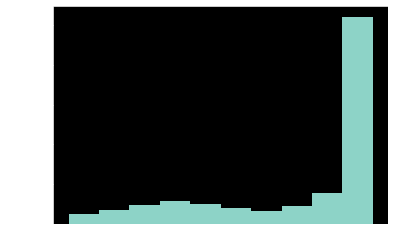

In [56]:
pd.Series(positive_predicted_scores).plot.hist()

In [57]:
negative_predicted_scores = cross_encoder.predict([ex.texts for ex in negative_input_examples])
pd.Series(negative_predicted_scores).describe()

count    9308.000000
mean        0.236007
std         0.202585
min         0.050964
25%         0.090538
50%         0.168475
75%         0.304945
max         0.981317
dtype: float64

<AxesSubplot:ylabel='Frequency'>

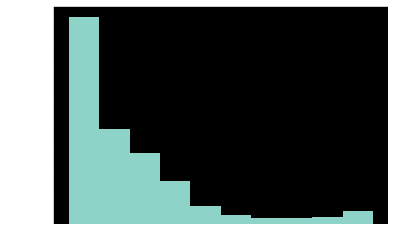

In [58]:
pd.Series(negative_predicted_scores).plot.hist()

In [ ]:
files_with_tasks_df.head()

In [ ]:
cross_encoder.predict([
    ["# tasks: neural networks \n", positive_input_pairs[0][1]]
])

In [ ]:
pairs_without_content =[[f"#repo: {repo}\n #path: {path}", f"# tasks: {tasks}"]
    for (repo, tasks, path) in zip(
        sample_files_with_tasks_df['repo'],
        sample_files_with_tasks_df['tasks'],
        sample_files_with_tasks_df['path'])]

In [ ]:
pairs_without_content[7]

In [ ]:
repo_path_task_scores = cross_encoder.predict([
    [f"#repo: {repo}\n #path: {path}", f"#tasks: {tasks}"]
    for (repo, tasks, path) in zip(
        sample_files_with_tasks_df['repo'],
        sample_files_with_tasks_df['tasks'],
        sample_files_with_tasks_df['path'])]
)


In [ ]:
repo_path_content_scores = cross_encoder.predict([
    [f"#repo: {repo}\n #path: {path}", f"#content: {content}"]
    for (repo, content, path) in zip(
        sample_files_with_tasks_df['repo'],
        sample_files_with_tasks_df['content'],
        sample_files_with_tasks_df['path'])]
)


In [301]:
pd.Series(repo_path_content_scores).describe()

count    4654.000000
mean        0.537175
std         0.137356
min         0.259086
25%         0.426667
50%         0.517186
75%         0.635878
max         0.931464
dtype: float64

In [302]:
pd.Series(repo_path_task_scores).describe()

count    4654.000000
mean        0.473706
std         0.309223
min         0.147257
25%         0.222930
50%         0.270712
75%         0.900784
max         0.937792
dtype: float64

In [46]:
sample_files_with_tasks_df.sort_values("score", ascending=False).head(20)

KeyError: 'score'

count    4654.000000
mean        0.070864
std         0.185280
min         0.011906
25%         0.018969
50%         0.022650
75%         0.030266
max         0.997173
dtype: float64

<AxesSubplot:ylabel='Frequency'>

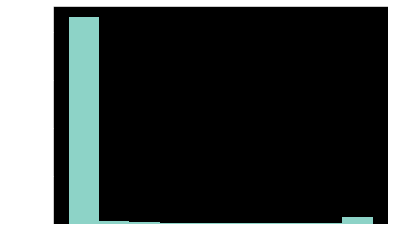

In [ ]:

__, tokenizer = seq2seq_utils.get_seq2seq_model_with_tokenizer("Salesforce/codet5-base-multi-sum")

In [ ]:
#tokenizer = transformers.RobertaTokenizerFast.from_pretrained("Salesforce/codet5-base-multi-sum") 

In [ ]:
decoder_start_token_id = tokenizer("<PATH_TASK_SEP>", add_special_tokens=False)['input_ids'][0]

In [ ]:
max_length = 64
inputs = tokenizer(example_contents, max_length=max_length,  truncation=True,
                        padding="max_length", return_tensors="pt")

In [ ]:
outputs = model.generate(input_ids=inputs["input_ids"].to(model.device),
             attention_mask=inputs["attention_mask"].to(model.device),
             length_penalty=0.8, num_beams=10, max_length=64, min_length=8)#, decoder_start_token_id=decoder_start_token_id)

In [ ]:
tokenizer.decode(outputs[7].tolist())

In [ ]:
output_paths = tokenizer.batch_decode(outputs.cpu(), skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [ ]:
predicted_doc_ids_df = pd.DataFrame.from_records([p.split("<PATH_TASK_SEP>") for p in output_paths], columns=["path", "tasks"])

In [ ]:
example_doc_ids_df = pd.DataFrame.from_records([p.split("<PATH_TASK_SEP>") for p in example_doc_idxs], columns=["path", "tasks"]) 

In [ ]:
predicted_doc_ids_df['tasks']

In [ ]:
example_doc_ids_df['tasks']

In [ ]:
model_inputs = [content + " predict docID: " for (content, doc_id) in zip(example_contents, example_doc_idxs)]

In [ ]:
model_inputs[1]

In [ ]:
sru_contents = '''

import torch
from torch import nn
from typing import List
import os
import json
import sru


rnn_class_type_mapping = {"lstm": nn.LSTM, "sru": sru.SRU}


class SentenceRNN(nn.Module):
    """
    sentence_transformers RNN wrapper
    """
'''

In [ ]:
dimension_reduction_contents = '''

import numpy as np
import tqdm
from sklearn import decomposition


class IncrementalHyperbolicMDS:
    def __init__(self, n_components, dtype="float16"):
        self.ipca = decomposition.IncrementalPCA(n_components=n_components)
        self.dtype = dtype

    def partial_fit(self, D):
        Y = -np.cosh(D)
        self.ipca.partial_fit(Y)
'''

In [ ]:
recommender_contents = '''
#export 

import scipy
import pandas as pd
import numpy as np


from sklearn import compose, feature_extraction, metrics
from functools import reduce, partial
import attr
from typing import Union
import umap
import altair


from game_recommender import steam_data
'''# + " predict docID: lambdaofgod <REPO_NAME_SEP> mlutil <REPO_PATH_SEP> mlutil/recommendation.py"

In [ ]:
text_mining_content = '''
def get_wordnet_similarity(
    word, another_word, similarity_method="resnik", pos=None, ic=None
):
    if ic is None:
        ic = wordnet_ic.ic("ic-semcor.dat")
    assert similarity_method in [
        "lin",
        "jcn",
        "resnik",
    ], "Unsupported similarity method: " + str(similarity_method)
    word_synset = wn.synsets(word, pos)[0]
    another_word_synset = wn.synsets(another_word, pos)[0]
    if similarity_method == "lin":
        return word_synset.lin_similarity(another_word_synset, ic)
    elif similarity_method == "jcn":
        return word_synset.jcn_similarity(another_word_synset, ic)
    else:
        return word_synset.res_similarity(another_word_synset, ic)
'''

In [ ]:
zsl_content = '''
import numpy as np
import attr
from toolz import partial
from scarce_learn.zero_shot import zsl_base

from sklearn import preprocessing
import torch
from torch import nn, optim
from scarce_learn.zero_shot import torch_util


class DEVISELayer(nn.Module):

    def __init__(self, n_features, n_class_features, margin, init_weights_std=0.1):
        super(DEVISELayer, self).__init__()
        init_weights = init_weights_std * torch.randn(n_features, n_class_features) 
        self.weights = nn.Parameter(data=init_weights.cuda())
        self.margin = margin

    def forward(self, X, y, label_embeddings):
        loss = torch.Tensor([0]).cuda()
        for i in range(X.shape[0]):
            loss += self._devise_loss(X[i], y[i], label_embeddings)
        return loss

    def _devise_loss(self, embedding, label, label_embeddings):
        indicator = torch.ones(label_embeddings.shape[0], dtype=bool)
        indicator[label] = 0
        per_class_loss = torch_util.similarity_based_hinge_loss(self.weights, embedding, label, label_embeddings)
        return nn.ReLU()(self.margin + per_class_loss).sum()

    def predict(self, X, label_embeddings):
        class_similarities = torch_util.bilinear_feature_similarity(self.weights, X, label_embeddings)
        return torch.argmax(class_similarities, axis=1)

'''

In [ ]:
evolutionary_content = '''
import attr
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import tqdm
import logging


try:
    import numba
except ImportError as e:
    logging.warning(
        "numba not found, you'll not be able to use mlutil.evolutionary_algorithms.multiobjective"
    )


def bounded_gaussian_noise_mutation(x, n_mutants, lo=0, hi=1, sigma=1e-2):
    noise = sigma * np.random.randn(n_mutants, x.shape[-1])
    return np.clip(x + noise, lo, hi)


@attr.s
class NSGAII:

    optimized_function = attr.ib()
    chromosome_size: int = attr.ib()
    mutation_function = attr.ib(default=bounded_gaussian_noise_mutation)
    random_initializer = attr.ib(default=np.random.rand)
    population_bounds = attr.ib(default=(0, 1))
    objective_names = attr.ib(default=("1st objective", "2nd objective"))
'''

In [ ]:
optimal_transport_content = '''
import numpy as np
import ot
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances


def get_stem_vectors(filtered_stems, keyed_vectors):
    return np.vstack(
        [
            np.mean([keyed_vectors[w] for w in stem_list], axis=0)
            for stem_list in filtered_stems
            if len(stem_list) > 0
        ]
    )


def get_word_vector_optimal_transport(
    word_vectors1, word_vectors2, ot_method=ot.sinkhorn, reg=0.01, normalize_dists=True
):
    cost = cosine_distances(word_vectors1, word_vectors2)
    height, width = cost.shape
    a = np.ones(height)
    b = np.ones(width)
    if normalize_dists:
        a = a / a.sum()
        b = b / b.sum()
    ot_matrix = ot_method(a, b, cost, reg=reg)
    return ot_matrix, (ot_matrix * cost).sum()

'''

In [ ]:
#model = model.cuda().half()

In [ ]:
optimal_transport_content

In [ ]:
model.device

In [ ]:
path_content = " predict docID: lambdaofgod <REPO_NAME_SEP> mlutil <REPO_PATH_SEP> mlutil/recommendation.py"

In [ ]:
tokenizer.decode(
    model.generate(**(tokenizer(path_content, return_tensors="pt").to(model.device)),
    num_beams=5, max_length=128, min_length=32)[0].tolist(), top_k=0, top_p=0.9
)

In [ ]:
paths = ["_nbdev.py", "haystack_search.py", "rss_feeds.py", "zero_shot_learning.py"]

In [ ]:
paths_series = "lambdaofgod <REPO_NAME_SEP> pytorch_hackathon <REPO_PATH_SEP> pytorch_hackathon <PATH_TASK_SEP> " + pd.Series(paths)

In [ ]:
tokenizer.decode(
    model.generate(**(tokenizer(paths_series[3], return_tensors="pt").to(model.device)),
    num_beams=10, max_length=128, min_length=16)[0].tolist(), #, top_p=0.8
)

In [ ]:
example = seq2seq_dataset[:32]

In [ ]:
import torch

In [ ]:
def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

In [ ]:
model = model.cuda()

In [ ]:
def embed_text(examples, tokenize=False):
    if tokenize:
        inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    else:
        inputs = {"input_ids": torch.tensor(examples["input_ids"]).to(model.device), "attention_mask": torch.tensor(examples["attention_mask"]).to(model.device)}
    with torch.no_grad():
        model_output = model.encoder(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [ ]:
embs_dataset = seq2seq_dataset.train_test_split(test_size=10000)['test'].map(embed_text,
    batched=True,
    batch_size=128
)

In [ ]:
embs_dataset[0].keys()#['labels'][0]

In [ ]:
embs_dataset.add_faiss_index("embedding")

In [ ]:
tokenizer.tokenize("metric learning", return_tensors="pt")

In [ ]:
type(embs_dataset[0]['embedding'])

In [ ]:
query_text = "implements zero-shot learning"

In [ ]:
query_emb = model.encoder(**tokenizer(query_text, return_tensors="pt").to(model.device))

In [ ]:
query_emb = query_emb.last_hidden_state.mean(axis=1)[0].to("cpu").detach().numpy()

In [ ]:
import numpy as np

In [ ]:
#query_emb = np.array(embs_dataset[0]['embedding'])

In [ ]:
files_df.iloc[0]['content']

In [ ]:
files_sample = files_with_tasks_df.iloc[::500]

In [ ]:
files_sample.head()

In [ ]:
[embs_dataset["contents"][i] for i in list(embs_dataset.search("embedding", query=query_emb.astype("float32")).indices)]

In [ ]:
embs_dataset

In [ ]:
import torch

In [ ]:
example_imports

In [ ]:
model.generate(**(tokenizer(example_imports, return_tensors="pt").to(model.device)),
    num_beams=20, max_length=128, min_length=32)

In [ ]:
encoder_output = model.encoder(**inputs.to(model.device)) #decoder_input_ids=torch.tensor([[decoder_start_token_id]]).to(model.device))

In [ ]:
unique_tasks = files_with_tasks_df['tasks'].str.split(',').explode().str.strip().unique()

In [ ]:
unique_tasks 

In [ ]:
encoder_output.last_hidden_state.shape

In [ ]:
tokenizer.decode((-lm_output.logits).argsort()[:,:,:5][0,0].tolist())

# TODO wyławianie istotnych informacji z konfigów

In [ ]:
%%time
generated_doc_ids = get_predicted_path_summary(example_contents, max_length=64, min_length=16, max_label_length=32)

In [ ]:
predicted_tasks = [d for d in generated_doc_ids]

In [ ]:
true_tasks = [d for d in example_doc_idxs]

In [ ]:
for p in zip(predicted_tasks, true_tasks, example_contents):
    print("#")
    print(p[2])
    print(p[0])
    print(p[1])